# Interpretation Notebook

In [2]:
library(dplyr)
library(Matrix)
library(ggplot2)
library(ggpubr)
library(xtable)
library(Seurat)
library(reshape2)
library(plotly)
library(gridExtra)
library(cowplot)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject


Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘cowplot’


The following object is masked from ‘package:ggpubr’:

    get_legend




### Load Sepsis Results

In [3]:
res = read.csv("~/sepsisres.csv")

In [4]:
head(res)

index              id   pheno    cell_state cell_type ncorrs      poscells
1 AAACCTGAGACGCTTT-1 P18F Control  TS2        T         -0.40975684 False   
2 AAACCTGAGCAATCTC-1 P20  Leuk-UTI BS1        B         -0.03276529 False   
3 AAACCTGAGTTTAGGA-1 P18F Control  TS2        T         -0.39238297 False   
4 AAACCTGCAAAGTGCG-1 P18F Control  MS2        Mono      -0.27001457 False   
5 AAACCTGCAAGTACCT-1 P17H Control  MS2        Mono      -0.05939984 False   
6 AAACCTGCACGAAATA-1 P18  Leuk-UTI MS4        Mono       0.01141681 False   
  negcells NAMPC1       NAMPC2        NAMPC3        NAMPC4       NAMPC5       
1 True     -0.004798240  0.0037787498 -0.0027310449 -0.001130937 -0.0011712229
2 False     0.001275772  0.0018899626 -0.0058938664 -0.001243946  0.0020981675
3 True     -0.005283813  0.0029592581 -0.0001401601  0.002822815 -0.0006915858
4 True     -0.005416165  0.0003330859  0.0024352050  0.003348973  0.0037334476
5 False    -0.003237256 -0.0018841637  0.0021716618  0.002015814  0.0038702387
6 False    -0.001706508 -0.0018660312  0.0010051002  0.001756787  0.0041271894

In [5]:
gene_expr = t(readRDS('/data/srlab/jkang/cna_sepsis/9_Sepsis_CNA/x_sparse.RDS'))

In [6]:
# Confirm cell order
sum(res$index==colnames(gene_expr))==dim(res)[1]

[1] TRUE

### Identify and refine to variable genes

In [7]:
# Identify and consider only top 5000 variable genes
n_var_genes = 5000
gene_sds = apply(gene_expr, 1, FUN = sd)
gene_sds = gene_sds[order(gene_sds, decreasing = TRUE)]

var_genes = names(gene_sds)[1:n_var_genes]
var_gene_expr = gene_expr[match(var_genes, rownames(gene_expr)),]

### Load Genesets, Helper Fns for GSEA

In [8]:
library(fgsea)
library(GSA)

In [9]:
geneset_files = c("/data/srlab/lrumker/MSigDB_Sets/c7.all.v7.0.symbols.gmt.txt", #Immune
"/data/srlab/lrumker/MSigDB_Sets/h.all.v7.0.symbols.gmt.txt", #Hallmark
"/data/srlab/lrumker/MSigDB_Sets/c2.all.v7.0.symbols.gmt.txt") #Cannonical

In [10]:
parseGeneSetGMT <-function(filepath, known_genes, sizeBound_Upper=500, sizeBound_Lower=0){
    # Note this function is always highly verbose
  Gene_Sets_DB = GSA.read.gmt(filepath)
  GeneSet_sizes = sapply(Gene_Sets_DB$genesets,length)
  recognized_genes = matrix(NA, nrow=length(GeneSet_sizes), ncol = max(GeneSet_sizes))
  for(i in c(1:length(GeneSet_sizes))){
    recognized_genes[i,c(1:GeneSet_sizes[i])] = Gene_Sets_DB$genesets[[i]]
  }
  recognized_genes = matrix(is.element(recognized_genes, known_genes), ncol = ncol(recognized_genes))
  GeneSet_sizes = apply(recognized_genes, 1, sum)
  retain_GeneSet = (GeneSet_sizes>=sizeBound_Lower)&(GeneSet_sizes<=sizeBound_Upper)
  Gene_Sets_DB$genesets = Gene_Sets_DB$genesets[retain_GeneSet]
  Gene_Sets_DB$geneset.names = Gene_Sets_DB$geneset.names[retain_GeneSet]
  Gene_Sets_DB$geneset.descriptions = Gene_Sets_DB$geneset.descriptions[retain_GeneSet]
  Gene_Sets_DB$geneset.sizes = GeneSet_sizes[retain_GeneSet]
  return(Gene_Sets_DB)
}

In [11]:
run_GSEA_byFile <-function(genesettype, rankList, filter_output=TRUE, 
                           GeneSet_SizeBound_Upper = 500, GeneSet_SizeBound_Lower = 15){
    # genesettype takes string values "immune", "canonical", or "immune"
    # rankList must be named with gene labels per value
    if(genesettype=="canonical"){
        i_file = 3
    }else if(genesettype=="hallmark"){
        i_file = 2
    }else if(genesettype=="immune"){
        i_file = 1
    }else{
        print("Geneset file label not recognized.")
        return
    }
    Gene_Sets_DB = parseGeneSetGMT(geneset_files[i_file], names(rankList), 
                                   GeneSet_SizeBound_Upper, GeneSet_SizeBound_Lower)
    input_genesets = Gene_Sets_DB$genesets
    names(input_genesets) = Gene_Sets_DB$geneset.names

    FGSEA_output = fgsea(input_genesets, rankList, nproc = 0, nperm=100000,
                         minSize = GeneSet_SizeBound_Lower, 
                         maxSize = GeneSet_SizeBound_Upper, 
                         gseaParam = 1, BPPARAM = NULL)
    if(filter_output){
        FGSEA_output = FGSEA_output[order(FGSEA_output$padj),]
        FGSEA_output = FGSEA_output[which(FGSEA_output$padj<0.05),c(1,3,4)]
        FGSEA_output = FGSEA_output[grep("PID_", FGSEA_output$pathway),]
    }
    return(FGSEA_output)
}

### Compute Gene Correlations Across All Cell Types

In [12]:
global_corrs_to_ncorrs = cor(t(as.matrix(var_gene_expr)), res$ncorrs)
names(global_corrs_to_ncorrs) = var_genes

In [13]:
FGSEA_output = run_GSEA_byFile("canonical", global_corrs_to_ncorrs)

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in fgseaSimple(...):
“There were 4 pathways for which P-values were not calculated properly due to unbalanced gene-level statistic values”


In [14]:
enriched_pathways = FGSEA_output
enriched_pathways

pathway                          padj         ES       
1  PID_RAC1_PATHWAY                 0.0002104644 0.7140738
2  PID_PDGFRB_PATHWAY               0.0010990431 0.5205673
3  PID_ERBB1_DOWNSTREAM_PATHWAY     0.0024271169 0.5371266
4  PID_TOLL_ENDOGENOUS_PATHWAY      0.0025296504 0.7394315
5  PID_CDC42_PATHWAY                0.0027475120 0.6090838
6  PID_TXA2PATHWAY                  0.0034570664 0.6394794
7  PID_IL6_7_PATHWAY                0.0156080181 0.5813927
8  PID_IL8_CXCR2_PATHWAY            0.0182946922 0.6217589
9  PID_AMB2_NEUTROPHILS_PATHWAY     0.0209703435 0.6476151
10 PID_LYSOPHOSPHOLIPID_PATHWAY     0.0272403231 0.5944042
11 PID_P38_ALPHA_BETA_PATHWAY       0.0309796670 0.6320522
12 PID_THROMBIN_PAR1_PATHWAY        0.0321151235 0.5938450
13 PID_CASPASE_PATHWAY              0.0331622580 0.5611990
14 PID_EPO_PATHWAY                  0.0398327903 0.6045434
15 PID_ECADHERIN_NASCENT_AJ_PATHWAY 0.0480730989 0.5773765

In [ ]:
#write.table(enriched_pathways, "/data/srlab/lrumker/MCSC_Project/mcsc_scratch/sepsis_enriched_pathways.csv", sep = ",")

### Enrichemnts by NAM-PC

In [15]:
# To store new local pathway enrichments
nampcs = c("NAMPC1", "NAMPC2", "NAMPC3", "NAMPC4", "NAMPC5")
nampc_pathways = data.frame(matrix(nrow=length(nampcs),ncol=1))
rownames(nampc_pathways) = nampcs
colnames(nampc_pathways) = "dummy"

for(nampc in nampcs){
    nampc_corrs = cor(t(as.matrix(var_gene_expr)), res[,which(colnames(res)==nampc)])
    names(nampc_corrs) = var_genes
    pathways = run_GSEA_byFile("canonical", nampc_corrs)$pathway
    
    # Store new local pathway enrichments, by state
    novel_local = pathways[which(is.na(match(pathways,colnames(nampc_pathways))))]
    if(length(novel_local)>0){
        nampc_pathways = data.frame(cbind(nampc_pathways, matrix(NA, length(nampcs), length(novel_local))))
        colnames(nampc_pathways)[(ncol(nampc_pathways)-length(novel_local)+1):ncol(nampc_pathways)] = novel_local
    }
    found_local = match(pathways, colnames(nampc_pathways))
    nampc_pathways[match(nampc,rownames(nampc_pathways)), found_local] = 1
}
nampc_pathways = nampc_pathways[,-c(1)] # remove dummy column

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in fgseaSimple(...):
“There were 2 pathways for which P-values were not calculated properly due to unbalanced gene-level statistic values”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”


In [16]:
pathway_keywords = c("RAC1", "ERBB1_DOWNSTREAM", "PDGFRB", "TOLL_ENDOGENOUS", "CDC42", "TXA", "IL6_7",
                       "IL8_CXCR2", "AMB2_NEUTROPHILS", "LYSOPHOSPHOLIPID", "THROMBIN_PAR1", "P38_ALPHA_BETA",
                     "CASPASE", "EPO", "ECADHERIN_NASCENT_AJ", "TELOMERASE", "HDAC_CLASSII", "IL12", "HIF1_TF",
                    "TRKR", "CXCR4", "AVB3_OPN", "MYC_ACTIV", "CD8_TCR", "CD8_TCR_DOWNSTREAM", "TCR", 
                     "IL12_STAT4", "IL2_PI3K", "IL2_STAT5", "ENDOTHELIN", "PTP1B", "IL2_")
pathway_descriptions = c("RAC1 signaling pathway", "ErbB1 downstream signaling", "PDGFR-beta signaling pathway", 
                         "Endogenous TLR signaling", "CDC42 signaling events", "Thromboxane A2 receptor signaling", 
                         "IL6-mediated signaling events",
                       "IL8- and CXCR2-mediated signaling events", "amb2 Integrin signaling",
                        "LPA receptor mediated events", "PAR1-mediated thrombin signaling events",
                        "Signaling mediated by p38-alpha and p38-beta","Caspase cascade in apoptosis",
                        "EPO signaling pathway", "E-cadherin signaling in the nascent adherens junction",
                        "Regulation of Telomerase", "Regulation of Telomerase", 
                         "Signaling events mediated by HDAC Class II", "IL12-mediated signaling events",
                        "HIF-1-alpha transcription factor network", "Neurotrophic factor-mediated Trk receptor signaling",
                        "CXCR4-mediated signaling events", "Osteopontin-mediated events", 
                        "Validated targets of C-MYC transcriptional activation", "TCR signaling in naïve CD8+ T cells",
                        "Downstream signaling in naïve CD8+ T cells", "TCR signaling in naïve CD4+ T cells",
                        "IL12 signaling mediated by STAT4", "IL2 signaling events mediated by PI3K",
                        "IL2 signaling events mediated by STAT5", "Endothelins", 
                         "Signaling events mediated by PTP1B", "IL2-mediated signaling events")

In [17]:
# Clean up pathway names
pathway_names = colnames(nampc_pathways)
for(i in c(1:length(pathway_names))){
    pathway_names[i] = substr(pathway_names[i], nchar("PID_")+1,nchar(pathway_names[i])-nchar("_PATHWAY"))
}
pathway_names[which(pathway_names=='IL12_')] = "IL12"
pathway_names[which(pathway_names=='HIF1_T')] = "HIF1_TF"
colnames(nampc_pathways) = pathway_names

In [18]:
for(i in c(1:length(pathway_keywords))){
    colnames(nampc_pathways)[which(colnames(nampc_pathways)==pathway_keywords[i])] = pathway_descriptions[i]
}

In [19]:
# Plot enrichments
melted_mat <- melt(as.matrix(nampc_pathways))
p_nampcs <- ggplot(melted_mat, aes(x=Var2, y=Var1)) +
  geom_tile(aes(fill = value)) +
  scale_fill_distiller(palette = "viridis") +
  labs(title = "Pathway Enrichments",
       y = "NAM-PC", x = "Pathway")

Warning message in pal_name(palette, type):
“Unknown palette viridis”


In [20]:
# Enrichment by cell type
cell_type_enrichment = read.csv("~/sepsisres_nampc_celltypes.csv")
row.names(cell_type_enrichment) = paste("NAM", cell_type_enrichment$X, sep = "-")
cell_type_enrichment = cell_type_enrichment[,-c(1)]
colnames(cell_type_enrichment) = c("T", "B", "Mono", "NK", "DC")
# Plot enrichments in cell types
melted_mat <- melt(as.matrix(cell_type_enrichment))
colnames(melted_mat)[3] = "Correlation"
p_celltype <- ggplot(melted_mat, aes(x=Var2, y=Var1)) +
  geom_tile(aes(fill = Correlation)) +
  #scale_fill_distiller(palette = "RdYlB") +
    scale_fill_gradientn(colours = c("red", "white", "navy"),
                       values = scales::rescale(c(-0.5, -0.05, 0, 0.05, 0.5)))+
  labs(title = "Cell Type Enrichments",
       y = "NAM-PC", x = "Major Cell Type")

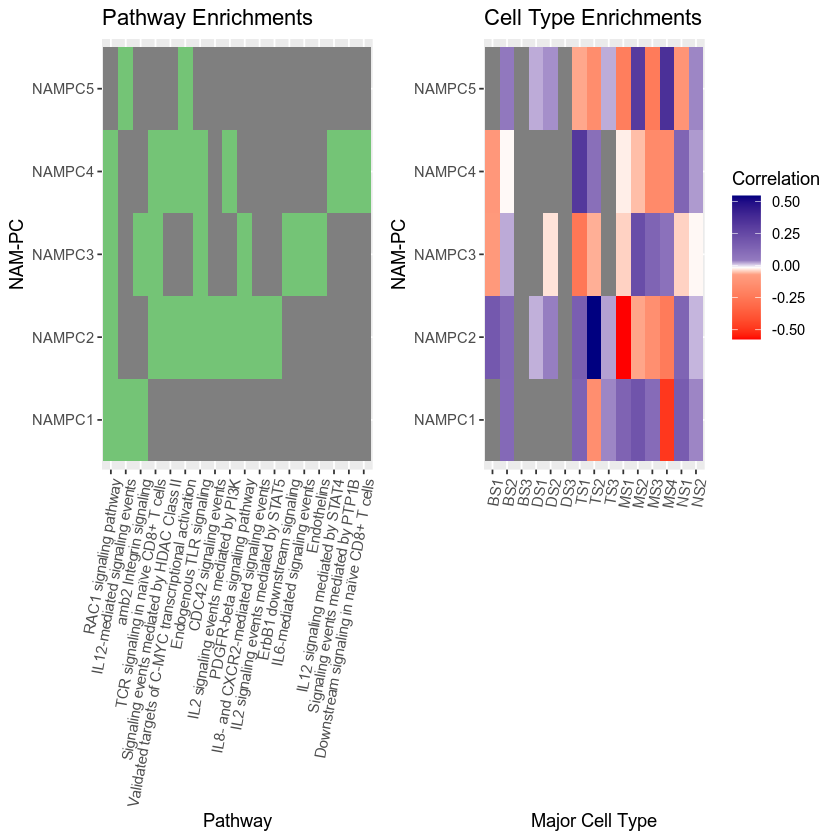

In [658]:
plot_grid(p_nampcs + theme(axis.text.x = element_text(angle = 80, hjust=1), legend.position = "none"),
             p_celltype + theme(axis.text.x = element_text(angle = 80, hjust=1)), 
          ncol=2, align="h", rel_widths = c(2.5, 3))

In [22]:
g = plot_grid(p_nampcs + theme(axis.text.x = element_text(angle = 80, hjust=1), legend.position = "none"),
             p_celltype + theme(axis.text.x = element_text(angle = 80, hjust=1)), 
          ncol=2, align="h", rel_widths = c(2.5, 3))
ggsave(file='../_figs/suppfig.sepsis.nampc_enrichments.pdf', g, width = 8, height = 5) #saves g
dev.off()

null device 
          1

### Annotating Within-Cluster Heterogeneity

In [522]:
characteristic_genes_within_state <-function(sel_state, depleted = TRUE, cna_obj, var_gene_expr, var_genes){
    # Returns correlations to cell identity in selected population, within cluster
    sel_cells = which(cna_obj$cell_state==sel_state)
    in_pop = rep(FALSE, length(sel_cells))
    if(depleted){
          in_pop[which(cna_obj$negcells[sel_cells]=='True')]=TRUE
    }else{
         in_pop[which(cna_obj$poscells[sel_cells]=='True')]=TRUE
    }
    corrs = cor(t(as.matrix(var_gene_expr[,sel_cells])), in_pop*1)
    names(corrs) = var_genes
    return(round(corrs,2))
}

In [523]:
characteristic_genes_within_type <-function(sel_type, sel_states, depleted = TRUE, cna_obj, var_gene_expr, var_genes){
    # Returns correlations to cell identity in selected population, within cluster
    sel_cells = which(cna_obj$cell_type==sel_type)
    in_pop = rep(FALSE, length(sel_cells))
    for(i in c(1:length(sel_states))){
        sel_state = sel_states[i]
        if(depleted){
            in_pop[which((cna_obj$negcells[sel_cells]=='True') & (cna_obj$cell_state[sel_cells]==sel_state))]=TRUE
        }else{
            in_pop[which((cna_obj$poscells[sel_cells]=='True') & (cna_obj$cell_state[sel_cells]==sel_state))]=TRUE
        }
    }

    corrs = cor(t(as.matrix(var_gene_expr[,sel_cells])), in_pop*1)
    names(corrs) = var_genes
    return(round(corrs,2))
}

In [524]:
depleted_states = data.frame(cbind(c("BS1", "BS2", "DS1", "DS2", "MS4", "TS1", "TS2"),
                                    c("B", "B", "DC", "DC", "Mono", "T", "T")))
colnames(depleted_states) = c("State", "Type")

# To store repliation of global pathway enrichments
global_pathways = data.frame(matrix(nrow=nrow(depleted_states),ncol=nrow(enriched_pathways)))
rownames(global_pathways) = depleted_states$State
colnames(global_pathways) = enriched_pathways$pathway

# To store new local pathway enrichments
local_pathways = data.frame(matrix(nrow=nrow(depleted_states),ncol=1))
rownames(local_pathways) = depleted_states$State
colnames(local_pathways) = "dummy"

for(i_row in c(1:nrow(depleted_states))){
    inState_depleted_corrs = characteristic_genes_within_state(depleted_states$State[i_row], 
                                                               depleted=TRUE, res, var_gene_expr, var_genes)
    inType_depleted_corrs = characteristic_genes_within_type(depleted_states$Type[i_row],
                                                             c(depleted_states$State[i_row]), 
                                                             depleted=TRUE, res, var_gene_expr, var_genes)
    state_pathways = run_GSEA_byFile("canonical", inState_depleted_corrs)$pathway
    type_pathways = run_GSEA_byFile("canonical", inType_depleted_corrs)$pathway
    
    # Store instances of global pathways replicated by type
    found_global = match(type_pathways, colnames(global_pathways))
    found_global = found_global[which(!is.na(found_global))]
    if(length(found_global)>0){
        global_pathways[match(depleted_states$State[i_row],rownames(global_pathways)), found_global] = 0.5
        type_pathways = type_pathways[which(is.na(match(type_pathways, colnames(global_pathways))))] # Only local remain
    }
    
    # Store instances of global pathways replicated by state
    found_global = match(state_pathways, colnames(global_pathways))
    found_global = found_global[which(!is.na(found_global))]
    if(length(found_global)>0){
        global_pathways[match(depleted_states$State[i_row],rownames(global_pathways)), found_global] = 1
        state_pathways = state_pathways[which(is.na(match(state_pathways, colnames(global_pathways))))] # Only local remain
    }
    
    # Store new local pathway enrichments, by type
    if(length(local_pathways)>0){
        novel_local = type_pathways[which(is.na(match(type_pathways,colnames(local_pathways))))]
        if(length(novel_local)>0){
            local_pathways = data.frame(cbind(local_pathways, matrix(NA, nrow(depleted_states), length(novel_local))))
            colnames(local_pathways)[(ncol(local_pathways)-length(novel_local)+1):ncol(local_pathways)] = novel_local
        }
        found_local = match(type_pathways, colnames(local_pathways))
        local_pathways[match(depleted_states$State[i_row],rownames(local_pathways)), found_local] = 0.5
    }
    
    # Store new local pathway enrichments, by state
    if(length(local_pathways)>0){
        novel_local = state_pathways[which(is.na(match(state_pathways,colnames(local_pathways))))]
        if(length(novel_local)>0){
            local_pathways = data.frame(cbind(local_pathways, matrix(NA, nrow(depleted_states), length(novel_local))))
            colnames(local_pathways)[(ncol(local_pathways)-length(novel_local)+1):ncol(local_pathways)] = novel_local
        }
        found_local = match(state_pathways, colnames(local_pathways))
        local_pathways[match(depleted_states$State[i_row],rownames(local_pathways)), found_local] = 1
    }
    
}

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (94.4% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (96.86% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (93.64% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (81.54% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in cor(t(as.matrix(var_gene_expr[, sel_cells])), in_pop * 1):
“the standard deviation is zero”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (95.76% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (95.96% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaSimple(...):
“There were 1 pathways for which P-values were not calculated properly due to unbalanced gene-level statistic values”
Warning message in cor(t(as.matrix(var_gene_expr[, sel_cells])), in_pop * 1):
“the standard deviation is zero”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (95.46% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (94.3% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (92.12% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (96.96% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (93.72% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (83.52% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (95.76% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (96.18% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


In [525]:
pathway_names = colnames(global_pathways)
for(i in c(1:length(pathway_names))){
    pathway_names[i] = substr(pathway_names[i], nchar("PID_")+1,nchar(pathway_names[i])-nchar("_PATHWAY"))
}
colnames(global_pathways) = pathway_names

In [526]:
pathway_names = colnames(local_pathways)
for(i in c(1:length(pathway_names))){
    pathway_names[i] = substr(pathway_names[i], nchar("PID_")+1,nchar(pathway_names[i])-nchar("_PATHWAY"))
}
pathway_names[which(pathway_names=='IL12_')] = "IL12"
pathway_names[which(pathway_names=='HIF1_T')] = "HIF1_TF"
colnames(local_pathways) = pathway_names
local_pathways = local_pathways[,-c(1)] # remove dummy column

In [527]:
# Plot enrichments that replicate global 
global_pathways_mod = global_pathways
for(i in c(1:length(pathway_keywords))){
    colnames(global_pathways_mod)[which(colnames(global_pathways_mod)==pathway_keywords[i])] = pathway_descriptions[i]
}
melted_cormat <- melt(as.matrix(global_pathways_mod))
p_global <- ggplot(melted_cormat, aes(x=Var2, y=Var1)) +
  geom_tile(aes(fill = value)) +
  scale_fill_distiller(palette = "Paired") +
  labs(title = "Also Enriched Globally",
       y = "Cell State", x = "Pathway")

In [528]:
local_pathways_mod = local_pathways
for(i in c(1:length(pathway_keywords))){
    colnames(local_pathways_mod)[which(colnames(local_pathways_mod)==pathway_keywords[i])] = pathway_descriptions[i]
}
melted_cormat <- melt(as.matrix(local_pathways_mod))
p_local <- ggplot(melted_cormat, aes(x=Var2, y=Var1)) +
  geom_tile(aes(fill = value)) +
  scale_fill_distiller(palette = "Paired") +
  labs(title = "Only Enriched Locally",
       y = "Cell State", x = "Pathway")

In [ ]:
# 1 -> orange -> w/r/t state
# 0.5 -> blue -> w/r/t type

Saving 6.67 x 6.67 in image



null device 
          1

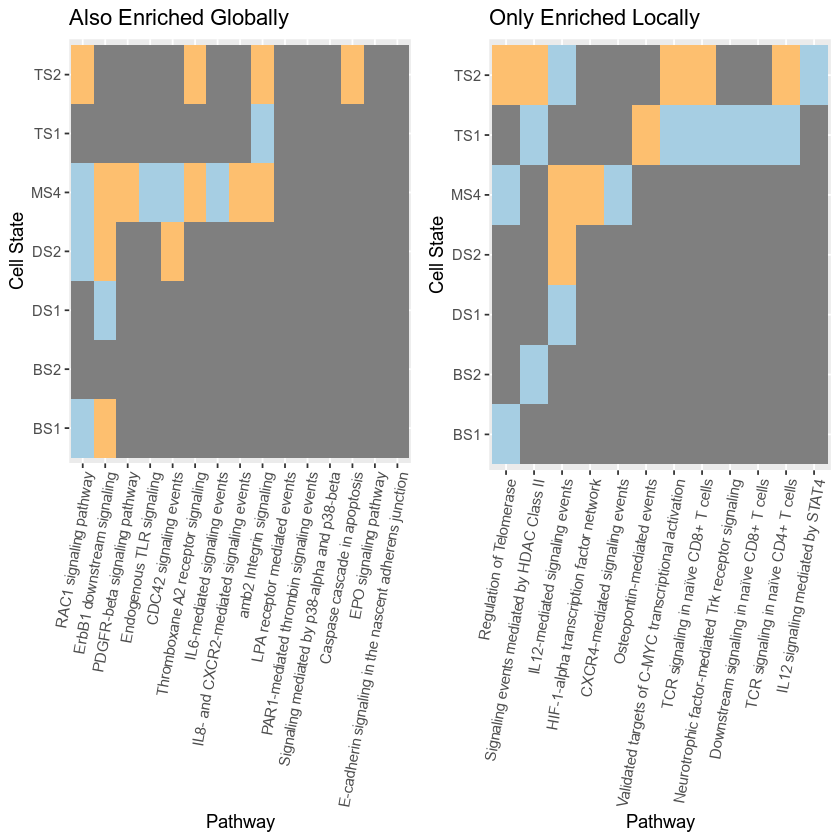

In [531]:
grid.arrange(p_global + theme(axis.text.x = element_text(angle = 80, hjust=1), legend.position = "none"),
             p_local + theme(axis.text.x = element_text(angle = 80, hjust=1), legend.position = "none"), 
             ncol=2)
g <- arrangeGrob(p_global + theme(axis.text.x = element_text(angle = 80, hjust=1), legend.position = "none"),
             p_local + theme(axis.text.x = element_text(angle = 80, hjust=1), legend.position = "none"), 
             ncol=2) #generates g
ggsave(file='../_figs/suppfig.sepsis.local_enrichment.jpg', g) #saves g
dev.off()

In [234]:
# Known: HDAC activitiy increases in sepsis
# Our result is consistent: Population BS1 has LOWER HDAC class II activity; there is LESS of BS1 in sepsis --> more HDAC activity
# HDACi (decrease HDAC activity) are therapeutic in sepsis 
# HDACi of HDAC6 (a Class 2 HDAC) has been shown to increase B cell populations
# Ref: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6359123/

In [235]:
## KNOWN
# Cytokine produced by B cells in response to antigenic stimulation
# Serum cytokine levels of IL-12 were increased in patients with sepsis (13)
# https://iv.iiarjournals.org/content/27/6/669.long
# WE FIND
# Lower IL-12 in BS2, of which there is less in sepsis ==> more IL-12 in sepsis

In [236]:
# https://febs.onlinelibrary.wiley.com/doi/full/10.1111/febs.15222
# Known:  Cellular hypoxia in sepsis --> activation of HIF1
# Note:  increased EPO was part of the global signal, this is not likely DS specific program 
# We find depletion of a population with lower HIF1-alpha --> increased HIF1-a

In [237]:
# HIF1 as above
# HDAC_CLASSII as above --> same HDAC6i results in increased monocytes too
# TRKR:  Neurotrophic factor-mediated Trk receptor signaling
# TrkA receptor is expressed by monocytes and its expression decreases during their differentiation into macrophages
# Less TRKR in depleted monos --> more TRKR in sepsis monos --> more macrophage differentiation? (Seems plausible, no ref yet found)
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2276974/
# Rest in global

In [238]:
# As above except AVB3_OPN_PATHWAY
# increased osteoponin cytokine in sepsis
# our depleted MS4 has less osteoponin --> consistent
#https://pubmed.ncbi.nlm.nih.gov/30781721/#:~:text=Sepsis%20is%20a%20life%2Dthreatening,involved%20in%20the%20inflammatory%20response.

In [239]:
# C-MYC for generation of T cell memory in viral infection
# https://royalsocietypublishing.org/doi/10.1098/rsob.150208

In [240]:
# CD8_TCR
# CXCR4:  T cell migration

# IL-12: IL-12 naïve T --> Th1 cells (production of IFN-γ and TNF-α)

In [270]:
library(ggplot2)
library(data.table)
library(reshape2)


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



Attaching package: ‘reshape2’


The following objects are masked from ‘package:data.table’:

    dcast, melt




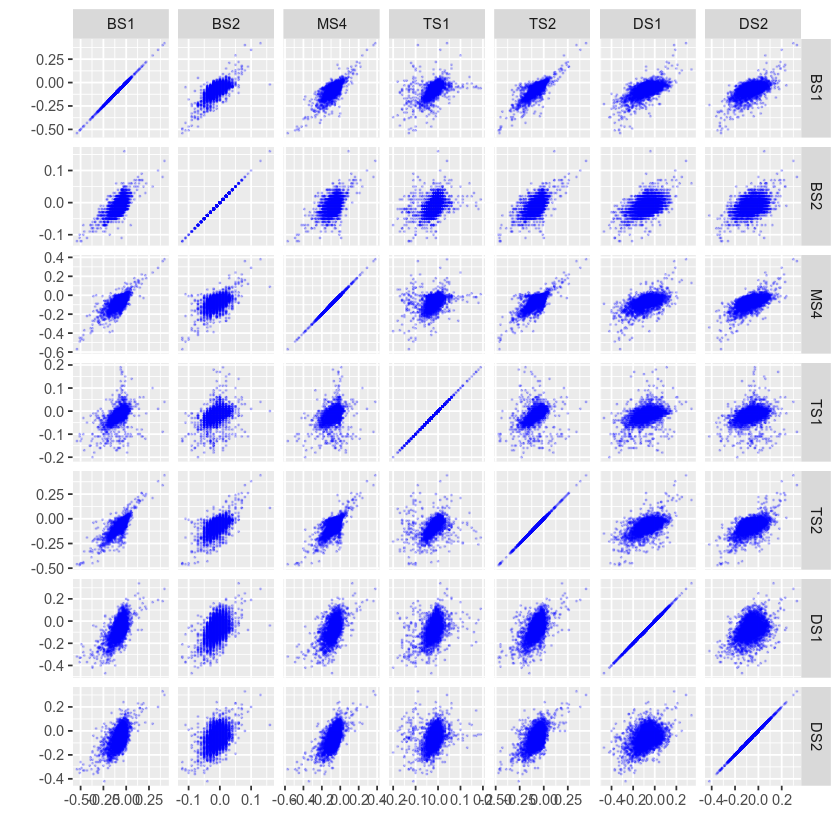

In [272]:
df.x= data.frame(cbind(BS1_inType_depleted_corrs, BS2_inType_depleted_corrs, MS4_inType_depleted_corrs, TS1_inType_depleted_corrs,
                      TS2_inType_depleted_corrs, DS1_inType_depleted_corrs, DS2_inType_depleted_corrs))
colnames(df.x) = c("BS1", "BS2", "MS4", "TS1", "TS2", "DS1", "DS2")
df.y = df.x
xDT <- data.table(melt(cbind(id=1:nrow(df.x),df.x),id="id",value.name="xval",variable.name="H"),key="id")
yDT <- data.table(melt(cbind(id=1:nrow(df.y),df.y),id="id",value.name="yval",variable.name="V"),key="id")
xy  <- xDT[yDT,allow.cartesian=T]

# simulates pairs() in base R
ggp = ggplot(xy,aes(x=xval,y=yval))
ggp = ggp + geom_point(colour = "blue", size = 0.2, alpha = 0.2)
ggp = ggp + facet_grid(V~H, scales="free")
ggp = ggp + labs(x="",y="")
print(ggp)

Warning message:
“Removed 78 rows containing missing values (geom_point).”


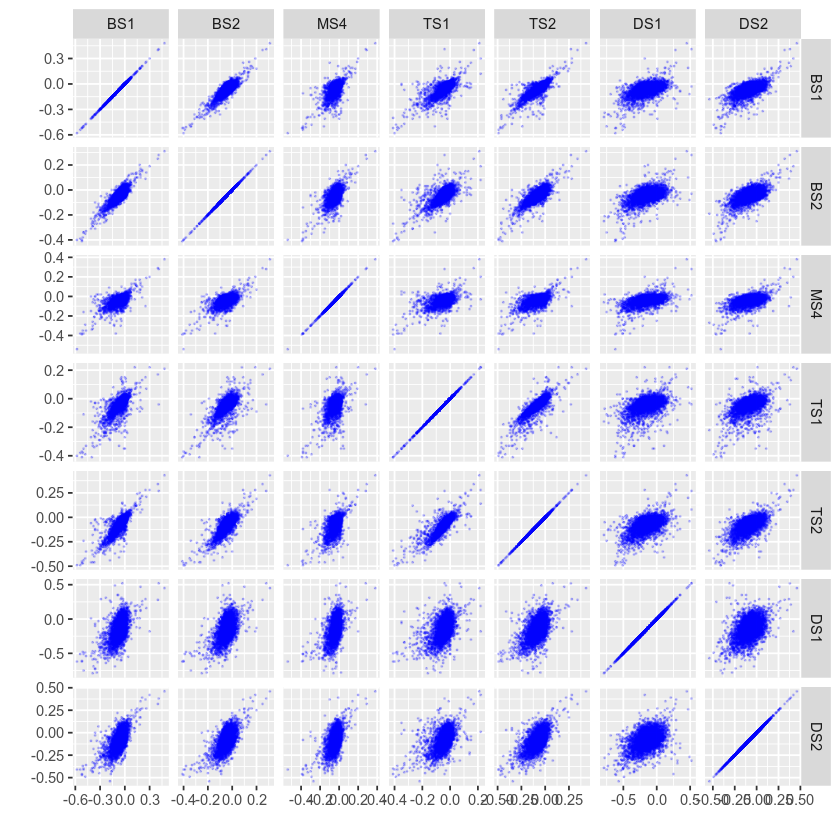

In [273]:
df.x= data.frame(cbind(BS1_inState_depleted_corrs, BS2_inState_depleted_corrs, MS4_inState_depleted_corrs, TS1_inState_depleted_corrs,
                      TS2_inState_depleted_corrs, DS1_inState_depleted_corrs, DS2_inState_depleted_corrs))
colnames(df.x) = c("BS1", "BS2", "MS4", "TS1", "TS2", "DS1", "DS2")
df.y = df.x
xDT <- data.table(melt(cbind(id=1:nrow(df.x),df.x),id="id",value.name="xval",variable.name="H"),key="id")
yDT <- data.table(melt(cbind(id=1:nrow(df.y),df.y),id="id",value.name="yval",variable.name="V"),key="id")
xy  <- xDT[yDT,allow.cartesian=T]

# simulates pairs() in base R
ggp = ggplot(xy,aes(x=xval,y=yval))
ggp = ggp + geom_point(colour = "blue", size = 0.2, alpha = 0.2)
ggp = ggp + facet_grid(V~H, scales="free")
ggp = ggp + labs(x="",y="")
print(ggp)

In [274]:
# GEP_genes
Gene_Sets_DB = parseGeneSetGMT(geneset_files[3], var_genes)

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

In [275]:
i_enriched = match(enriched_pathways$pathway,Gene_Sets_DB$geneset.names)
GEP_genes = unique(unlist(Gene_Sets_DB$genesets[i_enriched]))

In [276]:
i_GEP_var_genes = match(GEP_genes, var_genes)
i_GEP_var_genes = i_GEP_var_genes[which(!is.na(i_GEP_var_genes))]
GEP_genes = var_genes[i_GEP_var_genes]

In [277]:
df.x = df.x[i_GEP_var_genes,]
colnames(df.x) = c("BS1", "BS2", "MS4", "TS1", "TS2", "DS1", "DS2")
df.y = df.x

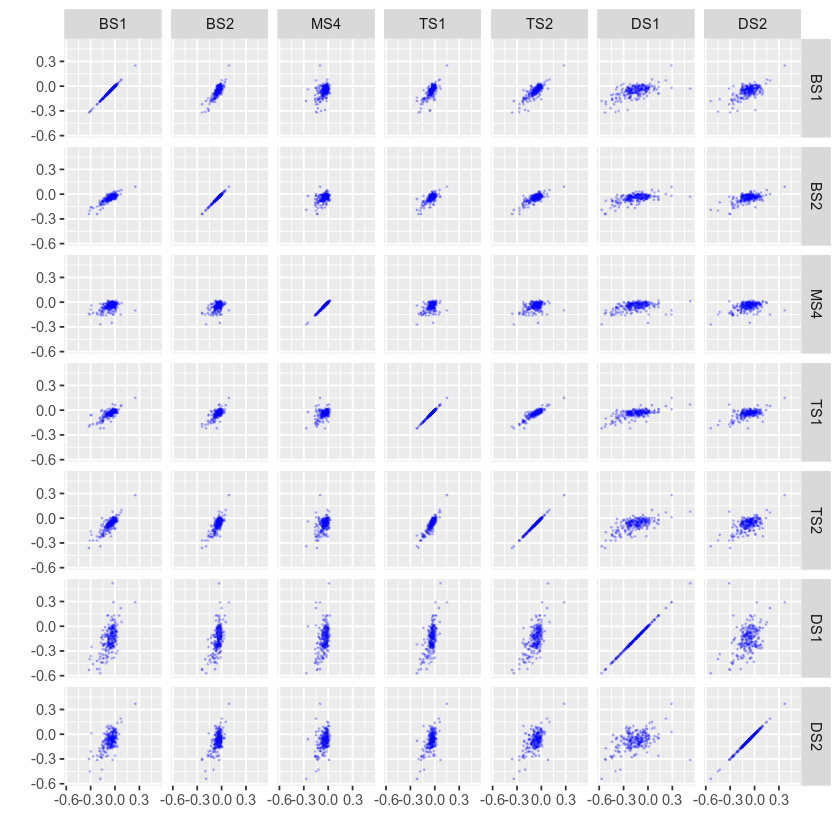

In [278]:
xDT <- data.table(melt(cbind(id=1:nrow(df.x),df.x),id="id",value.name="xval",variable.name="H"),key="id")
yDT <- data.table(melt(cbind(id=1:nrow(df.y),df.y),id="id",value.name="yval",variable.name="V"),key="id")
xy  <- xDT[yDT,allow.cartesian=T]

min_corr = min(df.x, na.rm = TRUE)
max_corr = max(df.x, na.rm = TRUE)

# simulates pairs() in base R
ggp = ggplot(xy,aes(x=xval,y=yval))
ggp = ggp + geom_point(colour = "blue", size = 0.2, alpha = 0.2)
ggp = ggp + facet_grid(V~H, scales="free")
ggp = ggp + labs(x="",y="") + xlim(min_corr, max_corr) + ylim(min_corr, max_corr)
print(ggp)

Warning message:
“Removed 78 rows containing missing values (geom_point).”


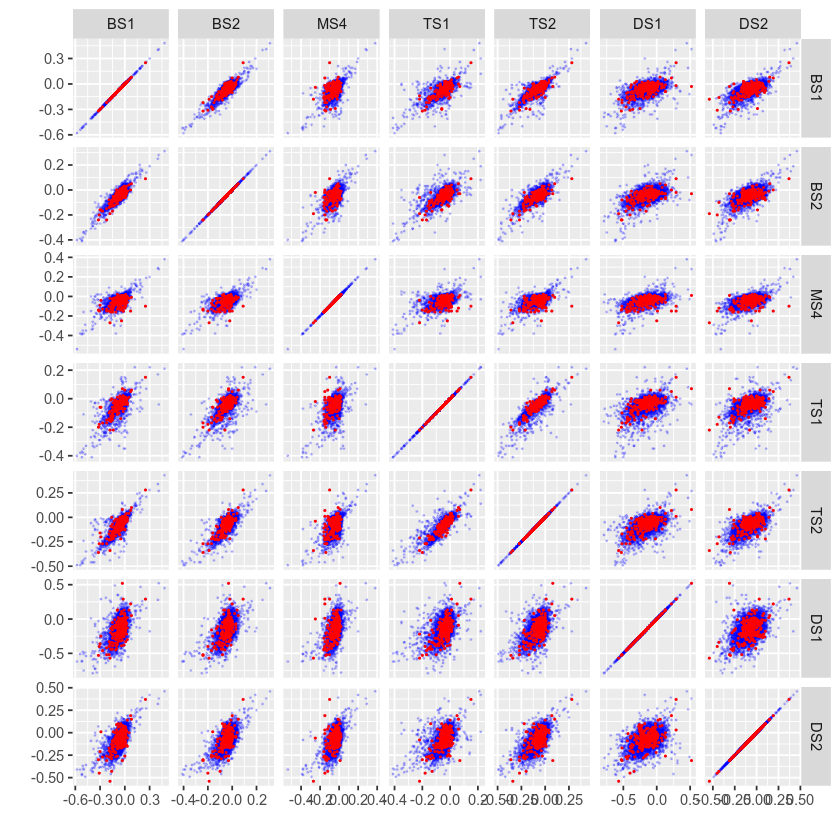

In [280]:
# Enriched Pathway Genes
df.x= data.frame(cbind(BS1_inState_depleted_corrs, BS2_inState_depleted_corrs, MS4_inState_depleted_corrs, TS1_inState_depleted_corrs,
                      TS2_inState_depleted_corrs, DS1_inState_depleted_corrs, DS2_inState_depleted_corrs))
colnames(df.x) = c("BS1", "BS2", "MS4", "TS1", "TS2", "DS1", "DS2")
df.y = df.x

xDT <- data.table(melt(cbind(id=1:nrow(df.x),df.x),id="id",value.name="xval",variable.name="H"),key="id")
yDT <- data.table(melt(cbind(id=1:nrow(df.y),df.y),id="id",value.name="yval",variable.name="V"),key="id")
xy  <- xDT[yDT,allow.cartesian=T]

min_corr = min(df.x, na.rm = TRUE)
max_corr = max(df.x, na.rm = TRUE)

df.x = df.x[i_GEP_var_genes,]
colnames(df.x) = c("BS1", "BS2", "MS4", "TS1", "TS2", "DS1", "DS2")
df.y = df.x

xDT <- data.table(melt(cbind(id=1:nrow(df.x),df.x),id="id",value.name="xval",variable.name="H"),key="id")
yDT <- data.table(melt(cbind(id=1:nrow(df.y),df.y),id="id",value.name="yval",variable.name="V"),key="id")
xy_GEP  <- xDT[yDT,allow.cartesian=T]

# simulates pairs() in base R
ggp = ggplot(xy,aes(x=xval,y=yval))
ggp = ggp + geom_point(colour = "blue", size = 0.2, alpha = 0.2)
ggp = ggp + facet_grid(V~H, scales="free")
ggp = ggp + labs(x="",y="") 
ggp = ggp + geom_point(data=xy_GEP, aes(xval, yval), colour = "red", size = 0.2, alpha = 1) 
print(ggp)

In [281]:
all_corrs = data.frame(cbind(BS1_inState_depleted_corrs, BS2_inState_depleted_corrs, MS4_inState_depleted_corrs, TS1_inState_depleted_corrs,
                      TS2_inState_depleted_corrs, DS1_inState_depleted_corrs, DS2_inState_depleted_corrs))

In [282]:
all_ranks = all_corrs
for(n_col in c(1:ncol(all_corrs))){
    all_ranks[,n_col] = rank(-all_ranks[,n_col])
}

In [283]:
mean_rank = apply(as.matrix(all_ranks), 1, mean)

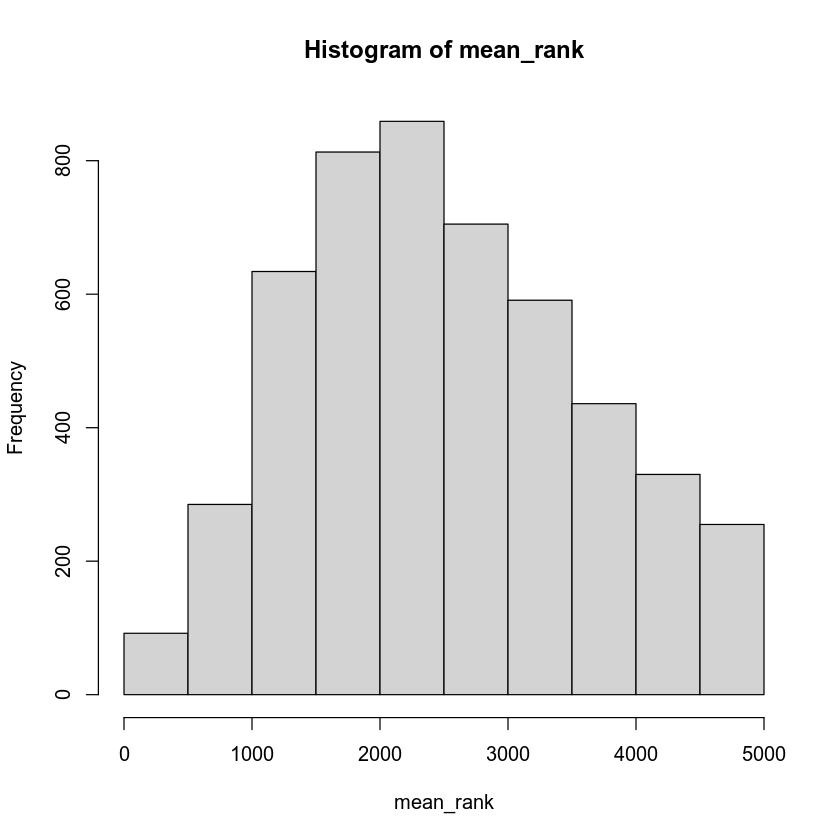

In [284]:
hist(mean_rank)

In [285]:
quantiles = quantile(mean_rank, c(0.010, 0.990))

In [286]:
sum(mean_rank<quantiles[1])

[1] 50

In [287]:
sum(mean_rank>quantiles[2])

[1] 50

In [288]:
mean_rank[mean_rank<quantiles[1]]

AC090498.1         NBEAL1          RPL17        C1orf56       CDC42SE1 
      1.857143       5.000000      16.357143      22.857143      20.785714 
       HNRNPH1        ATP5EP2       SH3BGRL3            FTL        GABARAP 
     15.142857      35.714286     240.857143     142.214286     276.285714 
          IL16          ZNF90         PPP1CB         CTNNB1          TRA2A 
     29.071429     111.642857     240.500000     203.214286     197.000000 
    AC009501.4          SRSF6      LINC00861         SNHG25          ESRRA 
     32.428571     158.714286     215.000000     138.000000      74.500000 
        UBXN11          SAR1A          GPR85          POLD4          LENG8 
    222.000000     250.928571      55.142857     253.642857     191.071429 
         GREM1         SH3BP2          SNHG9           PAN3          HLA-G 
     74.214286     296.357143      77.285714     224.071429     164.142857 
        MRPL53        MT-ATP8         PLXND1         GIGYF1        TSPAN32 
    207.071429     262.428571     257.785714     304.357143     210.071429 
         RPL41         RNASEK        METTL12          TIPIN           COCH 
    126.928571     309.428571     192.071429     130.857143      58.285714 
          HES4         FAM76A          RAB12           NME2           UBA7 
    302.785714     174.714286     307.071429      63.214286     235.500000 
          FLCN        HSD17B7          PI4KA  RP11-1000B6.3 LL22NC03-2H8.5 
    208.071429     263.214286     159.928571     180.928571     153.571429

In [289]:
mean_rank[mean_rank>quantiles[2]]

HLA-DRA    MT-ND3       VIM   MT-ATP6    MT-ND2    MT-CYB    MT-ND1    MYL12A 
 4925.429  4995.286  4947.643  4984.857  4988.214  4980.500  4968.071  4976.500 
    ACTG1    MT-ND4     CALM2     UQCRB    EEF1B2   HNRNPA1      YBX1    MT-CO3 
 4959.857  4995.714  4868.929  4986.714  4892.786  4963.786  4890.500  4994.929 
    ARPC2     ARPC3   ARHGDIB      BTF3     H3F3A    PABPC1      TPT1     H3F3B 
 4864.714  4926.357  4947.571  4973.714  4911.929  4937.500  4940.429  4900.214 
   MT-ND5      NACA      CFL1      DDX5     EIF3E     HMGB1     RPS20      NPM1 
 4889.071  4927.143  4917.929  4887.357  4931.643  4902.071  4946.643  4975.714 
     SUB1    CHCHD2    NAP1L1      RPL9      RPL7    MYL12B HNRNPA2B1      LCP1 
 4938.500  4876.214  4863.786  4935.214  4983.429  4938.286  4900.429  4869.500 
     SKP1     EVI2B     SARAF      PTMA    HNRNPK    MT-CO1     RPS13    MT-CO2 
 4898.071  4908.071  4906.143  4882.429  4887.857  4981.286  4867.214  4952.214 
    RPL39    EEF1A1 
 4979.071  4926.000

In [290]:
extreme_up_genes = names(mean_rank[mean_rank<quantiles[1]])
extreme_down_genes = names(mean_rank[mean_rank>quantiles[2]])
extreme_shared_genes = c(extreme_up_genes,extreme_down_genes)

In [295]:
FGSEA_output = run_GSEA_byFile("canonical", mean_rank)
FGSEA_output = FGSEA_output[grep("PID", FGSEA_output$pathway),]

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nperm = 1e+05, nproc = 0, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (4.24% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“All values in the stats vector are greater than zero and scoreType is "std", maybe you should switch to scoreType = "pos".”
Warning message in fgseaSimple(...):
“There were 1 pathways for which P-values were not calculated properly due to unbalanced gene-level statistic values”


In [297]:
head(FGSEA_output)

pathway padj ES

Warning message:
“Removed 78 rows containing missing values (geom_point).”


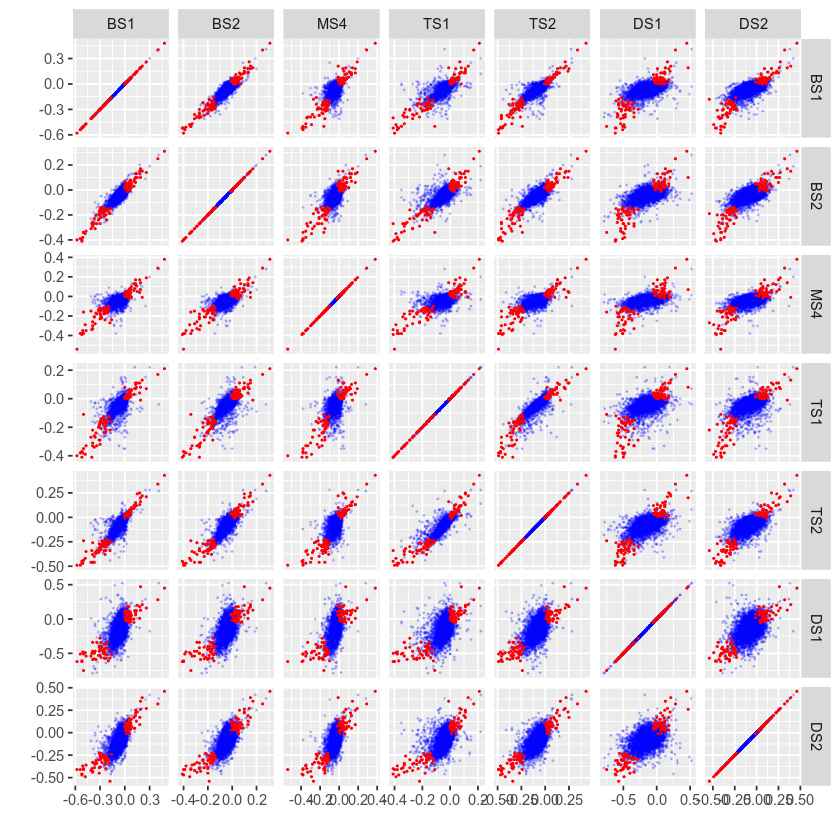

In [298]:
# Extreme Shared Genes 
df.x= data.frame(cbind(BS1_inState_depleted_corrs, BS2_inState_depleted_corrs, MS4_inState_depleted_corrs, TS1_inState_depleted_corrs,
                      TS2_inState_depleted_corrs, DS1_inState_depleted_corrs, DS2_inState_depleted_corrs))
colnames(df.x) = c("BS1", "BS2", "MS4", "TS1", "TS2", "DS1", "DS2")
df.y = df.x

xDT <- data.table(melt(cbind(id=1:nrow(df.x),df.x),id="id",value.name="xval",variable.name="H"),key="id")
yDT <- data.table(melt(cbind(id=1:nrow(df.y),df.y),id="id",value.name="yval",variable.name="V"),key="id")
xy  <- xDT[yDT,allow.cartesian=T]

min_corr = min(df.x, na.rm = TRUE)
max_corr = max(df.x, na.rm = TRUE)

df.x = df.x[match(extreme_shared_genes, var_genes),]
colnames(df.x) = c("BS1", "BS2", "MS4", "TS1", "TS2", "DS1", "DS2")
df.y = df.x

xDT <- data.table(melt(cbind(id=1:nrow(df.x),df.x),id="id",value.name="xval",variable.name="H"),key="id")
yDT <- data.table(melt(cbind(id=1:nrow(df.y),df.y),id="id",value.name="yval",variable.name="V"),key="id")
xy_GEP  <- xDT[yDT,allow.cartesian=T]

# simulates pairs() in base R
ggp = ggplot(xy,aes(x=xval,y=yval))
ggp = ggp + geom_point(colour = "blue", size = 0.2, alpha = 0.2)
ggp = ggp + facet_grid(V~H, scales="free")
ggp = ggp + labs(x="",y="") 
ggp = ggp + geom_point(data=xy_GEP, aes(xval, yval), colour = "red", size = 0.2, alpha = 1) 
print(ggp)

In [299]:
test_geneset = Gene_Sets_DB$genesets[match("PID_RAC1_PATHWAY",Gene_Sets_DB$geneset.names)][[1]]

In [301]:
test_geneset = extreme_down_genes[grep("MT-", extreme_down_genes)]

Warning message:
“Removed 78 rows containing missing values (geom_point).”
Warning message:
“Removed 1078 rows containing missing values (geom_point).”


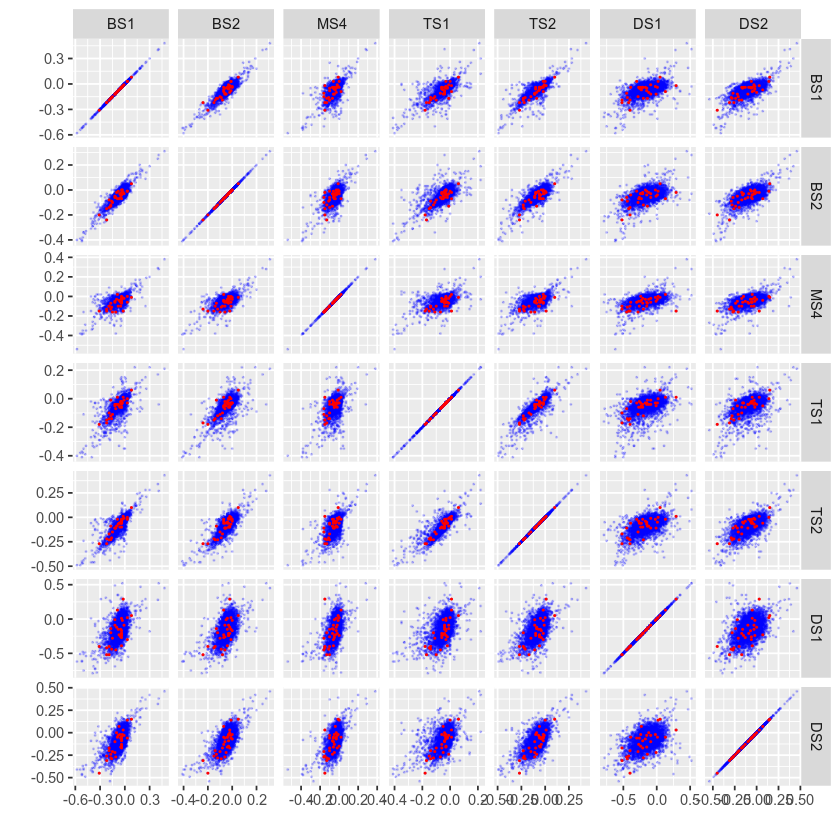

In [300]:
# Extreme Shared Genes 
df.x= data.frame(cbind(BS1_inState_depleted_corrs, BS2_inState_depleted_corrs, MS4_inState_depleted_corrs, TS1_inState_depleted_corrs,
                      TS2_inState_depleted_corrs, DS1_inState_depleted_corrs, DS2_inState_depleted_corrs))
colnames(df.x) = c("BS1", "BS2", "MS4", "TS1", "TS2", "DS1", "DS2")
df.y = df.x

xDT <- data.table(melt(cbind(id=1:nrow(df.x),df.x),id="id",value.name="xval",variable.name="H"),key="id")
yDT <- data.table(melt(cbind(id=1:nrow(df.y),df.y),id="id",value.name="yval",variable.name="V"),key="id")
xy  <- xDT[yDT,allow.cartesian=T]

min_corr = min(df.x, na.rm = TRUE)
max_corr = max(df.x, na.rm = TRUE)

df.x = df.x[match(test_geneset, var_genes),]
colnames(df.x) = c("BS1", "BS2", "MS4", "TS1", "TS2", "DS1", "DS2")
df.y = df.x

xDT <- data.table(melt(cbind(id=1:nrow(df.x),df.x),id="id",value.name="xval",variable.name="H"),key="id")
yDT <- data.table(melt(cbind(id=1:nrow(df.y),df.y),id="id",value.name="yval",variable.name="V"),key="id")
xy_GEP  <- xDT[yDT,allow.cartesian=T]

# simulates pairs() in base R
ggp = ggplot(xy,aes(x=xval,y=yval))
ggp = ggp + geom_point(colour = "blue", size = 0.2, alpha = 0.2)
ggp = ggp + facet_grid(V~H, scales="free")
ggp = ggp + labs(x="",y="") 
ggp = ggp + geom_point(data=xy_GEP, aes(xval, yval), colour = "red", size = 0.2, alpha = 1) 
print(ggp)

In [303]:
slim_gene_expr = var_gene_expr[-match(extreme_shared_genes, rownames(var_gene_expr)),]
slim_genes = var_genes[-match(extreme_shared_genes, rownames(var_gene_expr))]

In [304]:
# Within TS1 State
TS1_inState_depleted_corrs = characteristic_genes_within_state("TS1", depleted=TRUE, res, slim_gene_expr, slim_genes)
print("Genes whose expression is most characteristic of the depleted population")
TS1_inState_depleted_corrs[order(-TS1_inState_depleted_corrs)][1:30]
print("Genes whose expression is most characteristic of the NON-depleted population")
TS1_inState_depleted_corrs[order(TS1_inState_depleted_corrs)][1:30]

# Within D cell type
TS1_inType_depleted_corrs = characteristic_genes_within_type("T","TS1", depleted=TRUE, res, slim_gene_expr, slim_genes)
print("Genes whose expression is most characteristic of the depleted population")
TS1_inType_depleted_corrs[order(-TS1_inType_depleted_corrs)][1:30]
print("Genes whose expression is most characteristic of the NON-depleted population")
TS1_inType_depleted_corrs[order(TS1_inType_depleted_corrs)][1:30]

keep_for_cor = which(!is.na(TS1_inState_depleted_corrs) & !is.na(TS1_inType_depleted_corrs))
print(cor(TS1_inState_depleted_corrs[keep_for_cor], TS1_inType_depleted_corrs[keep_for_cor]))

[1] "Genes whose expression is most characteristic of the depleted population"


TYROBP  TMSB10  S100A8   KLRB1  IGFBP7  FCER1G   CLIC3   SPON2  IFITM1   KLRF1 
   0.22    0.22    0.15    0.15    0.15    0.14    0.14    0.13    0.12    0.12 
  CHST2     TXK    GNLY   CXXC5    LST1    GZMB   RAB24 SIGLEC7   CEBPD IRF2BPL 
   0.12    0.11    0.10    0.08    0.07    0.07    0.07    0.07    0.06    0.06 
 GOLIM4  S100A9  IFITM3  LGALS2     CD7    TRDC   PTGDS   CTBP2    GSAP  BOLA2B 
   0.06    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05

[1] "Genes whose expression is most characteristic of the NON-depleted population"


IL32   CD3D   TRAC RPL23A   RPS3   CCL5  RPL30   RPSA   RPS7    B2M  RPL21 
 -0.35  -0.35  -0.33  -0.29  -0.28  -0.27  -0.27  -0.26  -0.26  -0.26  -0.26 
 RPLP0  HLA-A  PTPRC RPL10A   GZMH  RPS3A  RPL26 RPL27A   CD3G  HLA-C   CD52 
 -0.25  -0.24  -0.24  -0.24  -0.24  -0.24  -0.24  -0.24  -0.24  -0.23  -0.23 
 RPL24   CD3E  RPS25    CD2   RPS2   RPL5  ANXA1  RPL14 
 -0.23  -0.23  -0.23  -0.23  -0.23  -0.22  -0.22  -0.22

[1] "Genes whose expression is most characteristic of the depleted population"


GNLY   NKG7   GZMB  KLRF1  SPON2  CLIC3 TYROBP  KLRB1 IGFBP7   CST7  KLRD1 
  0.19   0.18   0.17   0.17   0.16   0.15   0.14   0.13   0.13   0.11   0.11 
 CHST2   TRDC TMSB10 FCER1G   PRF1   CCL4   CMC1 IFITM1  EFHD2 FGFBP2  CXXC5 
  0.11   0.10   0.10   0.09   0.09   0.09   0.08   0.08   0.07   0.07   0.07 
 LAIR2   CCL5 S100A8   CTSW    CD7 PTPN12  PTGDS  KLRC1 
  0.07   0.06   0.06   0.06   0.06   0.06   0.06   0.06

[1] "Genes whose expression is most characteristic of the NON-depleted population"


RPL34   TRAC  RPS18  RPS25   RPS6 RPL13A  RPL21   CD3D RPL23A   RPS8   RPS2 
 -0.18  -0.17  -0.17  -0.16  -0.16  -0.16  -0.16  -0.15  -0.15  -0.15  -0.15 
   LTB   RPSA  RPLP0 RPL10A  RPL30   LDHB   RPS3 RPL35A  RPL13   IL32   RPL5 
 -0.14  -0.14  -0.14  -0.14  -0.14  -0.14  -0.14  -0.14  -0.14  -0.13  -0.13 
  RPS7  RPS4X  RPS16  RPS23  RPL31  RPS3A  RPL26 RPL27A 
 -0.13  -0.13  -0.13  -0.13  -0.13  -0.13  -0.13  -0.13

[1] 0.8092011


In [305]:
FGSEA_output = run_GSEA_byFile("canonical", TS1_inType_depleted_corrs)
FGSEA_output = FGSEA_output[grep("PID", FGSEA_output$pathway),]

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nperm = 1e+05, nproc = 0, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (83.41% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


In [306]:
head(FGSEA_output)

pathway               padj       ES        
1 PID_CD8_TCR_PATHWAY   0.02045229 -0.5757305
2 PID_MYC_ACTIV_PATHWAY 0.04528580 -0.5464855

In [307]:
# Within MS4 State
MS4_inState_depleted_corrs = characteristic_genes_within_state("MS4", depleted=TRUE, res, slim_gene_expr, slim_genes)
print("Genes whose expression is most characteristic of the depleted population")
MS4_inState_depleted_corrs[order(-MS4_inState_depleted_corrs)][1:30]
print("Genes whose expression is most characteristic of the NON-depleted population")
MS4_inState_depleted_corrs[order(MS4_inState_depleted_corrs)][1:30]

# Within D cell type
MS4_inType_depleted_corrs = characteristic_genes_within_type("Mono","MS4", depleted=TRUE, res, slim_gene_expr, slim_genes)
print("Genes whose expression is most characteristic of the depleted population")
MS4_inType_depleted_corrs[order(-MS4_inType_depleted_corrs)][1:30]
print("Genes whose expression is most characteristic of the NON-depleted population")
MS4_inType_depleted_corrs[order(MS4_inType_depleted_corrs)][1:30]

keep_for_cor = which(!is.na(MS4_inState_depleted_corrs) & !is.na(MS4_inType_depleted_corrs))
print(cor(MS4_inState_depleted_corrs[keep_for_cor], MS4_inType_depleted_corrs[keep_for_cor]))

[1] "Genes whose expression is most characteristic of the depleted population"


RPS27        TMSB10         RPS19         RPL32         CRIP1 
         0.28          0.20          0.13          0.12          0.11 
        RPS12        RPS15A         RPL10           LTB         IFI30 
         0.10          0.10          0.10          0.09          0.08 
     C9orf142         RPS29         RPL12        ZNF302         RPS15 
         0.07          0.07          0.07          0.06          0.06 
        RAB24          IL32          CD52        UQCRHL        ATP5L2 
         0.06          0.05          0.05          0.05          0.05 
       BOLA2B          GNLY          CCL5          TRAC RP5-1171I10.5 
         0.05          0.04          0.04          0.04          0.04 
       IFITM1          CD3E         RPL36         RPS18           LAT 
         0.04          0.04          0.04          0.04          0.04

[1] "Genes whose expression is most characteristic of the NON-depleted population"


MNDA     LYZ S100A12    SRGN    VCAN    CSTA  MS4A6A    CTSS    SAT1    EIF1 
  -0.38   -0.30   -0.30   -0.29   -0.25   -0.25   -0.23   -0.22   -0.22   -0.21 
C14orf2   ANXA1   RPS24  SEC61G MT-ND4L    RGS2   GAPDH   ITM2B   SUMO2    CD44 
  -0.20   -0.20   -0.20   -0.18   -0.18   -0.18   -0.17   -0.17   -0.17   -0.17 
   FGL2   NEAT1   PTPRC    RHOA    RAC1   COX7B    POMP   ACTR2    GLRX   IFI16 
  -0.17   -0.16   -0.16   -0.16   -0.16   -0.16   -0.16   -0.16   -0.16   -0.16

[1] "Genes whose expression is most characteristic of the depleted population"


RPS27        TMSB10         RPL32        RPS15A         RPS12 
         0.36          0.24          0.21          0.17          0.14 
        RPL10         RPS29         RPLP1         CRIP1         RPL12 
         0.13          0.12          0.12          0.09          0.09 
        RPL36         RPS15         RPS28         RPS19 RP11-1143G9.4 
         0.09          0.09          0.08          0.08          0.07 
        RPS14         RPL13         RPS18        RPL18A         RPL34 
         0.07          0.07          0.06          0.06          0.06 
        RAB24         RPL11  RP11-108M9.4        RPL36A      C9orf142 
         0.05          0.04          0.04          0.03          0.03 
       ZNF302          FGD2    AC092580.4           LAT         RPL28 
         0.03          0.03          0.03          0.03          0.03

[1] "Genes whose expression is most characteristic of the NON-depleted population"


SRGN    MNDA    SAT1    CTSS    CSTA    EIF1  FCER1G   COTL1   ANXA1    POMP 
  -0.39   -0.38   -0.33   -0.30   -0.28   -0.28   -0.27   -0.27   -0.26   -0.26 
  PLAC8   ITM2B    RHOA    ACTB    AIF1   NEAT1    NPC2   PTPRC    CD63    RAC1 
  -0.25   -0.25   -0.25   -0.25   -0.24   -0.24   -0.24   -0.24   -0.24   -0.24 
  SUMO2   COX7B C14orf2   ITGB2   TIMP1   ARPC5   DUSP1   H2AFZ     B2M S100A10 
  -0.24   -0.24   -0.23   -0.23   -0.23   -0.23   -0.23   -0.23   -0.23   -0.22

[1] 0.8752561


In [308]:
FGSEA_output = run_GSEA_byFile("canonical", MS4_inType_depleted_corrs)
FGSEA_output = FGSEA_output[grep("PID", FGSEA_output$pathway),]

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nperm = 1e+05, nproc = 0, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (97.33% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaSimple(...):
“There were 1 pathways for which P-values were not calculated properly due to unbalanced gene-level statistic values”


In [309]:
head(FGSEA_output)

pathway                      padj        ES        
1 PID_HIF1_TFPATHWAY           0.003602698 -0.5510728
2 PID_RAC1_PATHWAY             0.006882433 -0.5446005
3 PID_IL8_CXCR2_PATHWAY        0.007731634 -0.5862681
4 PID_AMB2_NEUTROPHILS_PATHWAY 0.011953255 -0.6157248
5 PID_TXA2PATHWAY              0.012746608 -0.5388575
6 PID_TRKR_PATHWAY             0.015071000 -0.5476939

In [310]:
# Within BS1 State
BS1_inState_depleted_corrs = characteristic_genes_within_state("BS1", depleted=TRUE, res, slim_gene_expr, slim_genes)
print("Genes whose expression is most characteristic of the depleted population")
BS1_inState_depleted_corrs[order(-BS1_inState_depleted_corrs)][1:30]
print("Genes whose expression is most characteristic of the NON-depleted population")
BS1_inState_depleted_corrs[order(BS1_inState_depleted_corrs)][1:30]

# Within B cell type
BS1_inType_depleted_corrs = characteristic_genes_within_type("B","BS1", depleted=TRUE, res, slim_gene_expr, slim_genes)
print("Genes whose expression is most characteristic of the depleted population")
BS1_inType_depleted_corrs[order(-BS1_inType_depleted_corrs)][1:30]
print("Genes whose expression is most characteristic of the NON-depleted population")
BS1_inType_depleted_corrs[order(BS1_inType_depleted_corrs)][1:30]

print(cor(BS1_inState_depleted_corrs, BS1_inType_depleted_corrs))

[1] "Genes whose expression is most characteristic of the depleted population"


RPS27    TMSB10    S100A8    RPS15A     RPL32     RPS29     RPS12     CRIP1 
     0.41      0.30      0.25      0.21      0.19      0.18      0.15      0.14 
   TYROBP     RPL12      LST1 LINC01272     RPS19    S100A9    S100A6  C9orf142 
     0.12      0.10      0.08      0.08      0.08      0.07      0.07      0.07 
    RPL36     RPLP1    UQCRHL      FGD2    ATP5L2    ADAM15    RPL36A     CSF3R 
     0.07      0.07      0.07      0.06      0.06      0.06      0.05      0.05 
  TNFAIP2     ODF3B     STAB1     ITGAX     FOSL2      NMT1 
     0.05      0.05      0.05      0.05      0.05      0.05

[1] "Genes whose expression is most characteristic of the NON-depleted population"


CD79A HLA-DPA1 HLA-DQB1 HLA-DRB1 HLA-DPB1    MS4A1     IGHD     BTG1 
   -0.41    -0.39    -0.38    -0.36    -0.36    -0.36    -0.36    -0.34 
HLA-DQA1     CD74    RPLP0    CXCR4    CD79B    TXNIP   LAPTM5     SNX2 
   -0.34    -0.33    -0.32    -0.32    -0.32    -0.30    -0.30    -0.30 
    RPSA    SEPT7    TCL1A    BIRC3     CD37     EIF1    RPL24    RPS11 
   -0.29    -0.29    -0.29    -0.29    -0.28    -0.28    -0.27    -0.27 
   SRSF5   EIF4A2     CD53    ITM2B      UBB      UBC 
   -0.27    -0.27    -0.27    -0.26    -0.26    -0.26

[1] "Genes whose expression is most characteristic of the depleted population"


RPS27    TMSB10     RPL32    S100A8    RPS15A     RPS29     RPS19     RPS12 
     0.40      0.29      0.21      0.19      0.18      0.17      0.15      0.13 
    RPL12    TYROBP     RPL36     RPS15     RPL35      IGHM LINC01272    RPL36A 
     0.12      0.06      0.06      0.06      0.05      0.05      0.04      0.04 
 C9orf142      NMT1    UQCRHL     ZC3H4   MAP3K12      LST1      MDM4      FGD2 
     0.04      0.04      0.04      0.04      0.04      0.03      0.03      0.03 
  TNFAIP2     RC3H1     RAB24     SPNS1    ATP5L2    ADAM15 
     0.03      0.03      0.03      0.03      0.03      0.03

[1] "Genes whose expression is most characteristic of the NON-depleted population"


HLA-DPA1    CD79A HLA-DPB1 HLA-DQB1    MS4A1 HLA-DRB1    RPLP0 HLA-DQA1 
   -0.36    -0.36    -0.34    -0.33    -0.33    -0.32    -0.32    -0.31 
     B2M    HLA-C     EIF1     RPSA    HLA-A    HLA-E    HLA-B     PPIA 
   -0.31    -0.30    -0.29    -0.28    -0.28    -0.28    -0.28    -0.27 
     UBC   LAPTM5    RPS11    SUMO2     CD53     BTG1   CORO1A    RPL24 
   -0.27    -0.27    -0.27    -0.27    -0.27    -0.26    -0.26    -0.26 
   SEPT7    BANK1    TXNIP  SLC25A6    RPL23     SNX3 
   -0.26    -0.26    -0.25    -0.25    -0.25    -0.25

          [,1]
[1,] 0.9512978


In [ ]:
FGSEA_output = run_GSEA_byFile("canonical", BS1_inType_depleted_corrs)
FGSEA_output = FGSEA_output[grep("PID", FGSEA_output$pathway),]

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nperm = 1e+05, nproc = 0, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (97.29% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


In [ ]:
head()